In [1]:
# Imports and Setup
import numpy as np
import os, csv
import matplotlib.pyplot as plt
import librosa
import IPython.display
import Tkinter

from bisect import bisect_right, bisect_left
# has to be set in order to show the image in notebook
%matplotlib inline 

try:
    os.chdir("./Resources")
except:
    pass

/Library/Python/2.7/site-packages/librosa/core/audio.py:33: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


In [2]:
def snap(times):
    first = times[0]
    qtz = lambda curr: curr - first
    return map(qtz, times)

def beat_range(bpm, length):
    cursor = 0
    times  = [] 
    step   = 60.00 / bpm

    while cursor < length:
        times.append(cursor)
        cursor += step
    
    return times

def find_le(a, x):
    'Find rightmost value less than or equal to x -- from Python Bisect docs'
    i = bisect_right(a, x)
    if i:
        return a[i-1]
    raise ValueError
    
def find_ge(a, x):
    'Find leftmost item greater than or equal to x'
    i = bisect_left(a, x)
    if i != len(a):
        return a[i]
    raise ValueError
    
def closest(a, x):
    less = find_le(a, x)
    more = float("inf")
    try:
        more = find_ge(a, x)
    except:
        print "Couldnt get bigger"

    return min(less, more)

def cross_correlation(times):
    delta = lambda x, y: abs(y - x) 
    bpm_distances = []
    
    for bpm in range(50, 161):
        timeEnd  = times[len(times) - 1]
        distance = 0
        beats    = beat_range(bpm, timeEnd)
        
        for beat in beats:
            distance += delta(closest(times, beat), beat)

        delta_beats = float(distance / len(beats))
        bpm_distances.append((bpm, delta_beats))
        
    return bpm_distances

def split(results):
    bpms    = []
    deltas  = []
    for element in results:
        bpms.append(element[0])
        deltas.append(element[1])
        
    return bpms, deltas

def distances(times):
    dists = []
    
    for index in range(len(times) - 1):
        dists.append(times[index + 1] - times[index])
        
    return dists

def beatHistogram(dists, binsize, maxbin):
    """
    In order to maintain rounded numbers the milliseconds are represented as integers between 0 and 100
    (TODO) Research solutions to this problem
    """
    histogram = {}
    index = 0.0
    
    for time in range(0, int(maxbin * 100), int(binsize * 100)):
        histogram[time] = 0
    
    for dist in dists:
        preciseDist = round(dist, 2) - (round(dist, 2) % binsize)
        histogram[round(preciseDist * 100)] += 1
        
    return histogram

In [3]:
y, sr = librosa.load('./amen-break-138.wav', duration=24.00)
IPython.display.Audio(data=y, rate=sr)

(0.0, 302.0, 0.0, 12.390368771974735)

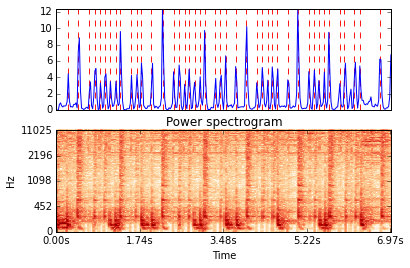

In [4]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

o_env = librosa.onset.onset_strength(y, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_S = librosa.logamplitude(S, ref_power=np.max)

onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
onset_times  = librosa.frames_to_time(onset_frames[:], sr=sr)

D = np.abs(librosa.stft(y))**2
plt.figure()

plt.subplot(2,1,2)
librosa.display.specshow(librosa.logamplitude(D, ref_power=np.max), x_axis='time', y_axis='log')
plt.title('Power spectrogram')

plt.subplot(2,1,1)
plt.plot(o_env, label='Onset strength')
plt.vlines(onset_frames, 0, o_env.max(), color='r', alpha=0.9, linestyle='--', label='Onsets')
plt.xticks([])
plt.axis('tight')

In [5]:
data = cross_correlation(snap(onset_times)) # sometimes giving 1/2 time bpm
sorted_by_second = sorted(data, key=lambda tup: tup[1])

print "Cross Correlation Guess:       %.2f beats per minute." % (sorted_by_second[0][0])
print "LibRosa Beat estimate guessed: %.2f beats per minute." % (librosa.beat.estimate_tempo(o_env))

Cross Correlation Guess:       78.00 beats per minute.
LibRosa Beat estimate guessed: 136.00 beats per minute.


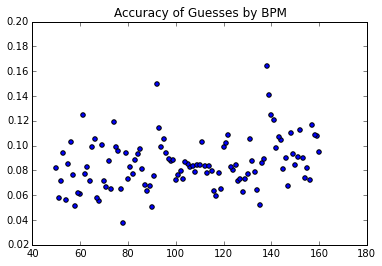

In [6]:
# Plot the Guesses by Average ∆s
# (TODO) Add labels and units
x, y = split(sorted_by_second) # split tuples into domain and range
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_title("Accuracy of Guesses by BPM")

# (TODO) Insert graph with beats laid on top of the waveform

In [7]:
gaps = distances(snap(onset_times))
print beatHistogram(gaps, 0.02, 0.51) # again in milliseconds

{0: 0, 2: 0, 4: 0, 6: 0, 8: 10, 10: 16, 12: 0, 14: 0, 16: 0, 18: 0, 20: 7, 22: 9, 24: 0, 26: 0, 28: 0, 30: 0, 32: 0, 34: 0, 36: 0, 38: 0, 40: 1, 42: 0, 44: 0, 46: 0, 48: 0, 50: 0}
